# **Chunking Strategy Exploration (Wikipedia Movie Plots)**

> _This notebook focuses exclusively on selecting an initial chunking strategy for the RAG ingestion pipeline using the **Wikipedia Movie Plots** dataset_.

## **Objective**
- Understand the internal structure of the `Plot` field:
    - Line breaks, paragraph boundaries, character distributions.
- Support chunking design decisions with data-driven metrics.
- Recommend values for:
  - `chunk_size`
  - `chunk_overlap`
  - `separator`
- Evaluate the suitability of line- or paragraph-aware chunking.


This notebook complements the general dataset EDA in `1.0-ilfn-initial-data-exploration.ipynb`, by narrowing the scope to chunking.

## **Imports and Configuration**

In [1]:
# --- Notebook setup and autoreload configuration ---
# This cell runs the initial setup script and enables the autoreload extension.
# The autoreload feature ensures that updates made to imported modules (e.g., in src/)
# are automatically reloaded without restarting the kernel.
%run notebook_setup.py

%load_ext autoreload

%autoreload 2

2026-01-26T11:11:30 | INFO | NOTEBOOK | Notebook environment configured successfully
2026-01-26T11:11:30 | INFO | NOTEBOOK | Project root: /home/ilfn/datascience/workspace/rag-movie-plots
2026-01-26T11:11:30 | DEBUG | NOTEBOOK | Added to sys.path:
  - /home/ilfn/datascience/workspace/rag-movie-plots/src
  - /home/ilfn/datascience/workspace/rag-movie-plots/src/backend
2026-01-26T11:11:30 | DEBUG | NOTEBOOK | PYTHONPATH: /home/ilfn/datascience/workspace/rag-movie-plots/src
2026-01-26T11:11:30 | DEBUG | NOTEBOOK | Current working directory: /home/ilfn/datascience/workspace/rag-movie-plots/notebooks


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

## **Load and Prepare the Dataset**

We load the dataset used in the RAG ingestion pipeline and focus only on the `Plot` field, which becomes `Document.page_content` during vectorization.

In [3]:
pd.set_option('display.max_colwidth', 500)

RAW_DIR = Path("../data/raw")

csv_path = RAW_DIR / "wiki_movie_plots_deduped.csv"  
df = pd.read_csv(csv_path)

df = df.dropna(subset=["Plot"]).copy()
df["Plot"] = df["Plot"].astype(str)

print("Rows:", len(df))
df[["Title", "Release Year", "Plot"]].head(3)

Rows: 34886


,Title,Release Year,Plot
0,Kansas Saloon Smashers,1901,"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave..."
1,Love by the Light of the Moon,1901,"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better."
2,The Martyred Presidents,1901,"The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice."


> This gives us a clean, text-only subset suitable for further chunking diagnostics and visual exploration.

## **Why Structure Matters for Chunking?**

Chunking is not only a **length** problem — it is also a **boundary selection** problem.

Movie plots often contain:
- Narrative sentences with long-range dependencies
- Scene transitions represented as line breaks (`\n`)

Some chunking strategies are **boundary-aware**, such as:
- `CharacterTextSplitter(separator="\n")`
- `Recursive` strategies

To determine whether such boundaries are meaningful, we analyze:
1. **Line and paragraph structure** — detect natural breakpoints
2. **Character length** — guide `chunk size` and `overlap`

## **Normalize Newline Patterns**

Wikipedia plots may include inconsistent newline conventions:
- Windows-style (`\r\n`)
- Extra blank lines
- Tabs and trailing spaces

We normalize only for _analysis_ so line and paragraph statistics are consistent.

In [4]:
def normalize_newlines(text: str) -> str:
    # Normalize \r\n → \n and remove \r
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    return text

df["plot_norm"] = df["Plot"].apply(normalize_newlines)

## **Structural Metrics: Characters, Lines, Paragraphs**

We compute several structural metrics per plot:

|Column	|Description|
|-------|-----------|
|`n_chars`|	Total number of characters|
|`n_lines`|	Number of \n-separated lines|
|`n_paragraphs`|	Number of \n\n-separated blocks|
|`avg_line_chars`|	Average number of characters per line|
|`max_line_chars`|	Maximum line length — important for `overlap` reuse and `chunk size`|


In [5]:
def count_lines(text: str) -> int:
    return text.count("\n") + 1

def split_paragraphs(text: str) -> list[str]:
    """
    Splits a raw text into paragraphs by detecting blank lines.

    A paragraph boundary is defined as:
    - a newline (`\n`)
    - followed by any amount of whitespace (spaces, tabs, etc.)
    - followed by another newline (`\n`)
    """
    blocks = re.split(r"\n\s*\n", text.strip())
    return [b for b in blocks if b.strip()]

def line_lengths(text: str) -> list[int]:
    lines = text.split("\n")
    return [len(line) for line in lines]


df["n_chars"] = df["plot_norm"].apply(len)
df["n_lines"] = df["plot_norm"].apply(count_lines)
df["paragraphs"] = df["plot_norm"].apply(split_paragraphs)
df["n_paragraphs"] = df["paragraphs"].apply(len)

df["line_lens"] = df["plot_norm"].apply(line_lengths)
df["avg_line_chars"] = df["line_lens"].apply(lambda x: float(np.mean(x)) if x else 0.0)
df["max_line_chars"] = df["line_lens"].apply(lambda x: int(np.max(x)) if x else 0)

df[["n_chars", "n_lines", "n_paragraphs", "avg_line_chars", "max_line_chars"]].describe()


,n_chars,n_lines,n_paragraphs,avg_line_chars,max_line_chars
count,34886.000000,34886.000000,34886.000000,34886.000000,34886.000000
mean,2162.257295,3.777246,1.001032,604.653121,784.259158
std,1814.821663,3.006200,0.067291,386.547975,474.038333
min,15.000000,1.000000,1.000000,15.000000,15.000000
25%,715.000000,1.000000,1.000000,380.525000,475.000000
50%,1654.000000,3.000000,1.000000,539.166667,721.000000
75%,3371.000000,6.000000,1.000000,728.809524,996.000000
max,36752.000000,53.000000,11.000000,9760.000000,16599.000000


## **Percentile Summary (Min, Max, p90, p95, p99)**

In [6]:
def print_summary(series: pd.Series, name: str):
    q90 = series.quantile(0.90)
    q95 = series.quantile(0.95)
    q99 = series.quantile(0.99)
    print(f"=== {name} ===")
    print(f"Min:      {series.min()}")
    print(f"Mean:     {series.mean():.2f}")
    print(f"Median:   {series.median():.2f}")
    print(f"90th pct: {q90:.2f}")
    print(f"95th pct: {q95:.2f}")
    print(f"99th pct: {q99:.2f}")
    print(f"Max:      {series.max()}")
    print("-" * 60)

print_summary(df["n_chars"], "Characters per Plot")
print_summary(df["n_lines"], "Number of Lines per Plot")
print_summary(df["n_paragraphs"], "Number of Paragraphs per Plot")
print_summary(df["max_line_chars"], "Max Characters in a Single Line")


=== Characters per Plot ===
Min:      15
Mean:     2162.26
Median:   1654.00
90th pct: 4477.50
95th pct: 5235.00
99th pct: 7416.30
Max:      36752
------------------------------------------------------------
=== Number of Lines per Plot ===
Min:      1
Mean:     3.78
Median:   3.00
90th pct: 8.00
95th pct: 9.00
99th pct: 13.00
Max:      53
------------------------------------------------------------
=== Number of Paragraphs per Plot ===
Min:      1
Mean:     1.00
Median:   1.00
90th pct: 1.00
95th pct: 1.00
99th pct: 1.00
Max:      11
------------------------------------------------------------
=== Max Characters in a Single Line ===
Min:      15
Mean:     784.26
Median:   721.00
90th pct: 1304.50
95th pct: 1552.00
99th pct: 2276.00
Max:      16599
------------------------------------------------------------


## **Distributions of Structural Features**

We analyze several structural properties of the plot texts to understand how formatting and length vary across the dataset. These distributions help identify:
- The **typical range** covering most plots
- The presence of **long-tail outliers**
- And whether line or paragraph boundaries are frequent and reliable enough to justify structure-aware chunking.

Rather than assuming all splitting strategies are equally valid, this analysis grounds chunking decisions in empirical evidence.


In [7]:
def hist(series: pd.Series, title: str, xlabel: str, bins: int = 80, xlim=None):
    plt.figure(figsize=(14,5))
    sns.histplot(series, bins=bins, kde=True, color="#2b6cb0")

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)

    plt.axvline(series.mean(), color="red", linestyle="--", label=f"Mean = {series.mean():.0f}")
    plt.axvline(series.median(), color="green", linestyle="--", label=f"Median = {series.median():.0f}")
    plt.axvline(series.quantile(0.95), color="purple", linestyle="--", label=f"95th pct = {series.quantile(0.95):.0f}")

    if xlim:
        plt.xlim(*xlim)
    plt.legend()

    plt.show()

def boxplot(
    series: pd.Series,
    title: str,
    xlabel: str,
    figsize=(12, 3),
    color="#48bb78"
):
    plt.figure(figsize=figsize)
    sns.boxplot(x=series, color=color)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)

    plt.show()

### **Character length per plot**

We begin by examining the **distribution of plot lengths measured in characters**. Character length provides a stable, format-independent signal that directly controls `chunk size` and fragmentation.

To properly capture both typical behavior and extreme cases, we visualize the full distribution and a zoomed view focusing on the bulk of the dataset.

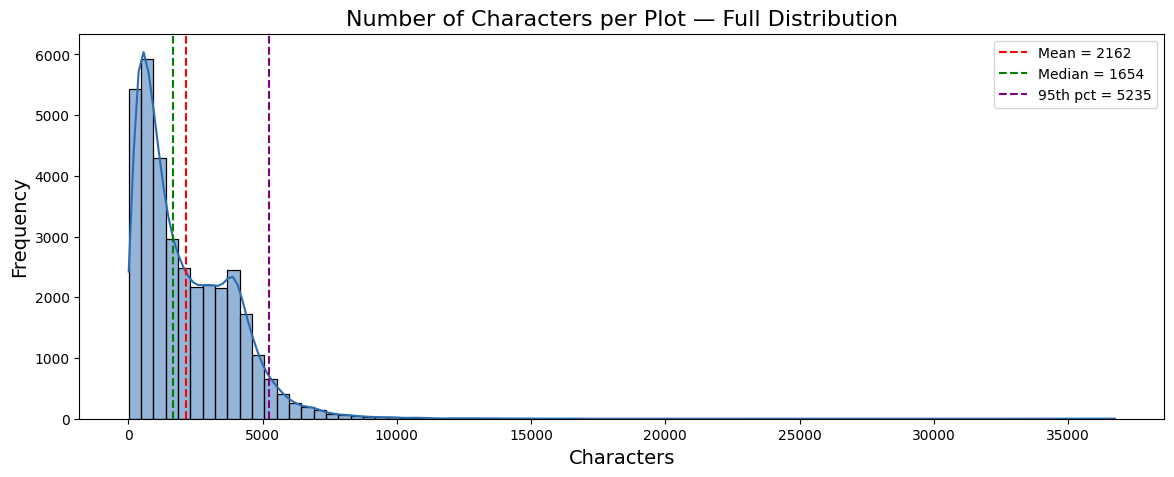

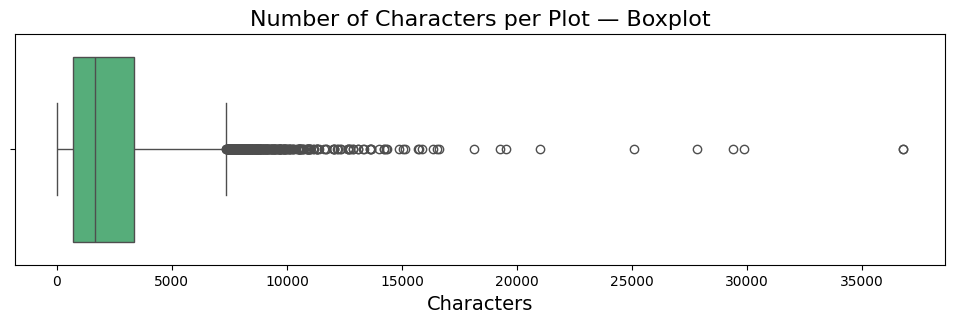

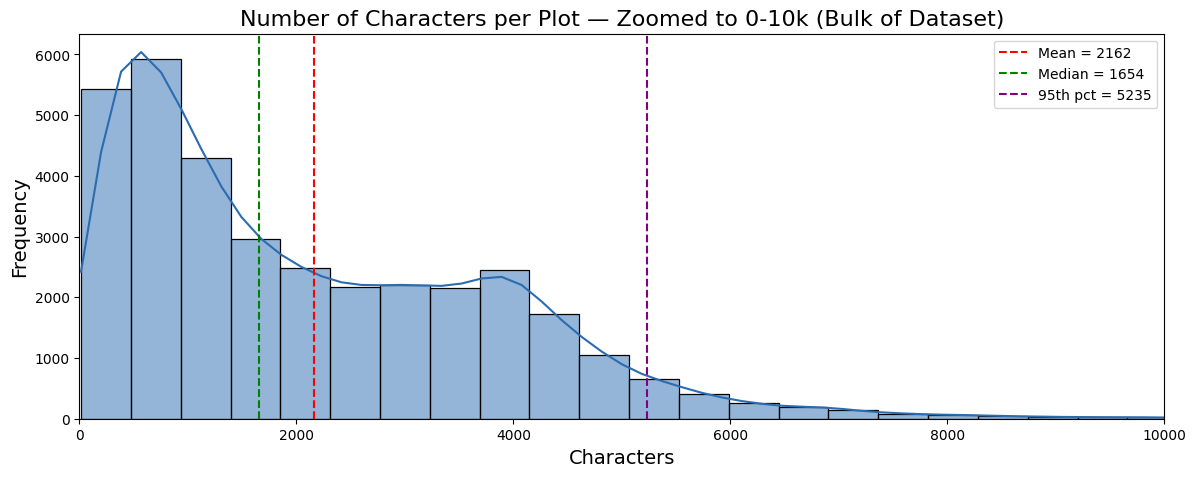

In [8]:
# Plot length in characters — full distribution (shows the long tail)
hist(
    df["n_chars"],
    "Number of Characters per Plot — Full Distribution",
    "Characters",
    bins=80
)

boxplot(
    df["n_chars"],
    "Number of Characters per Plot — Boxplot",
    "Characters"
)

# Plot length in characters — zoomed view (focus on the bulk of plots)
hist(
    df["n_chars"],
    "Number of Characters per Plot — Zoomed to 0-10k (Bulk of Dataset)",
    "Characters",
    bins=80,
    xlim=(0, 10000)
)

### **Line structure**

Next, we examine **how many lines each plot contains**. Because many chunking strategies rely on newline boundaries (or are indirectly constrained by them), the number of lines serves as a proxy for how **segmented** the text is at a structural level.

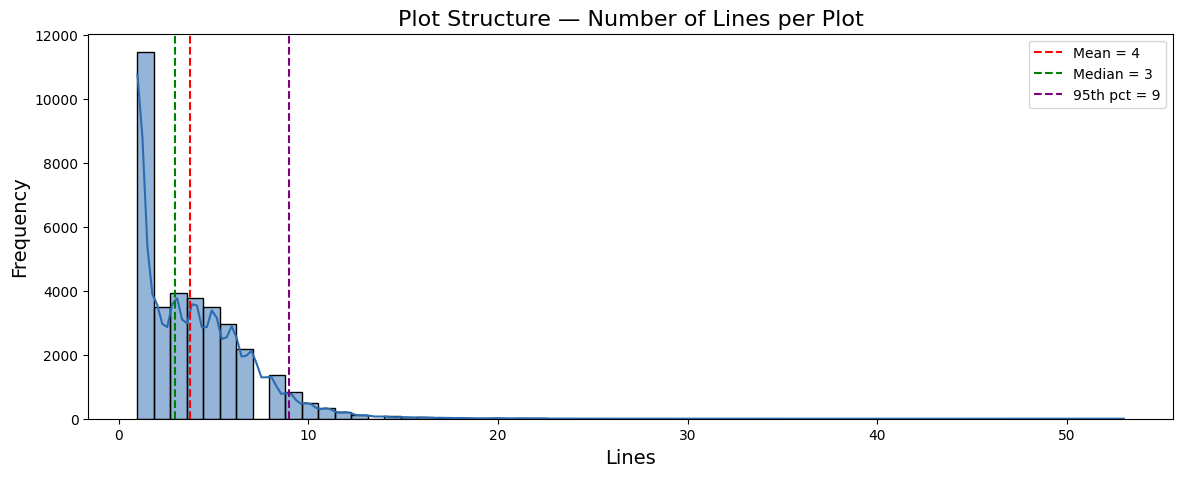

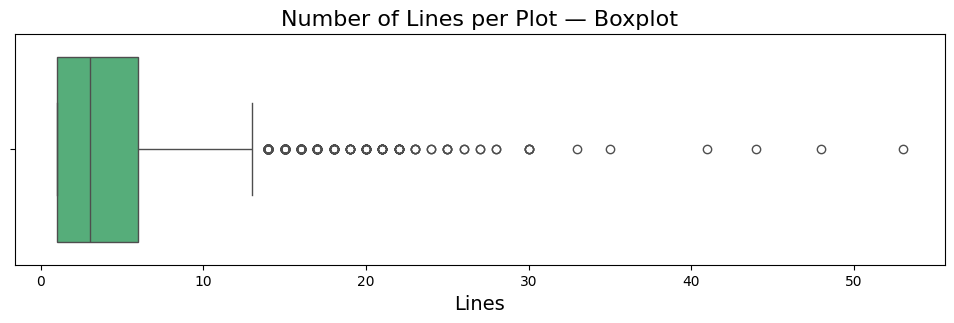

In [9]:
hist(
    df["n_lines"],
    "Plot Structure — Number of Lines per Plot",
    "Lines",
    bins=60
)

boxplot(
    df["n_lines"],
    "Number of Lines per Plot — Boxplot",
    "Lines"
)

### **Paragraph structure**

We now analyze the **number of paragraphs per plot**, typically inferred by splitting on blank lines (e.g., `"\n\n"`). **Paragraph boundaries** are often treated as higher-quality semantic separators, under the assumption that they group coherent ideas.

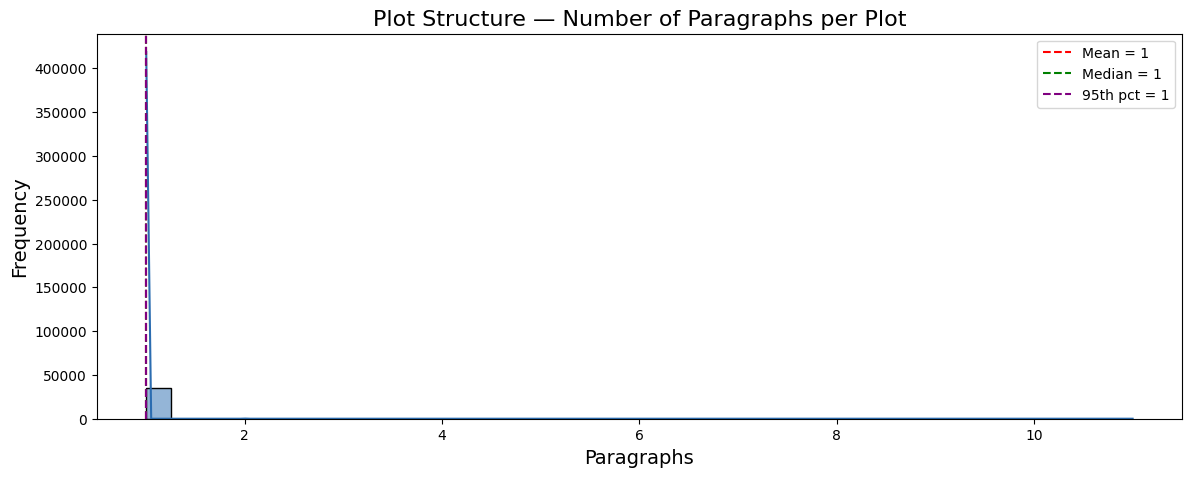

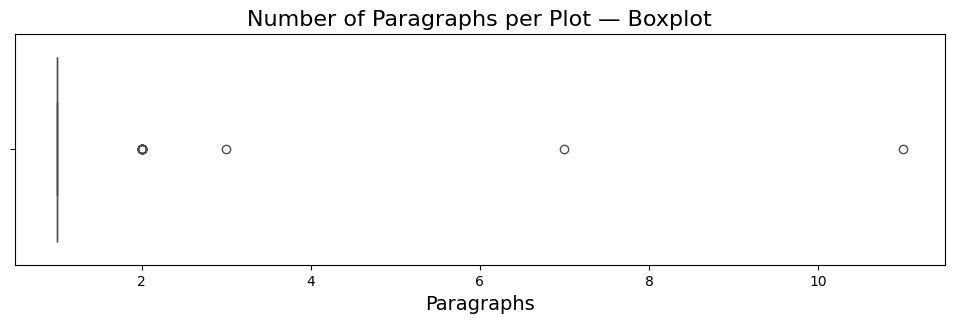

In [10]:
hist(
    df["n_paragraphs"],
    "Plot Structure — Number of Paragraphs per Plot",
    "Paragraphs",
    bins=40
)

boxplot(
    df["n_paragraphs"],
    "Number of Paragraphs per Plot — Boxplot",
    "Paragraphs"
)

### **Maximum line length**

Finally, we inspect the **maximum line length (in characters)** within each plot. This metric is critical for newline-aware splitters, since a single very long line can invalidate assumptions about alignment, `overlap` reuse, and `chunk size` consistency.

As before, we use both full and zoomed views to distinguish typical behavior from extreme cases.

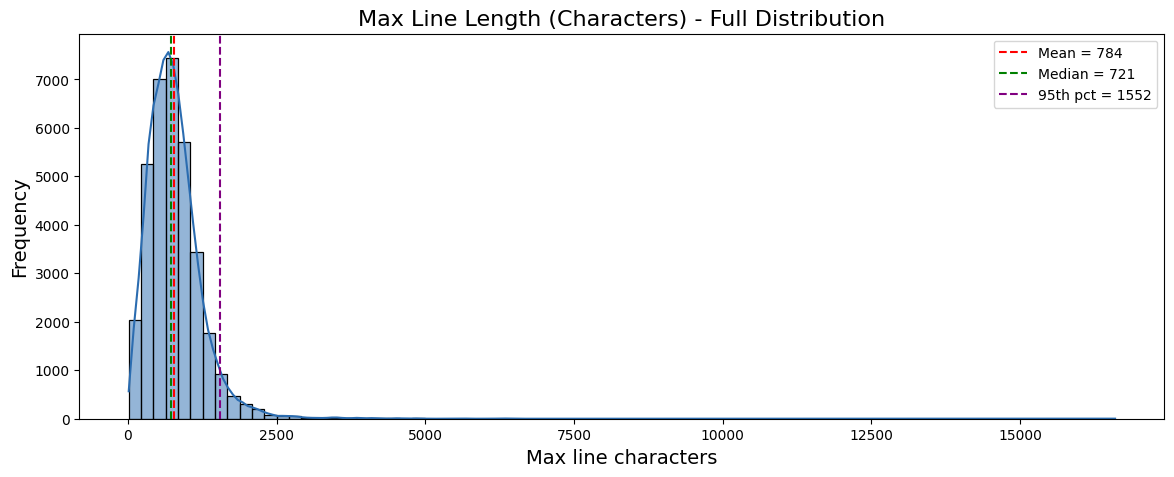

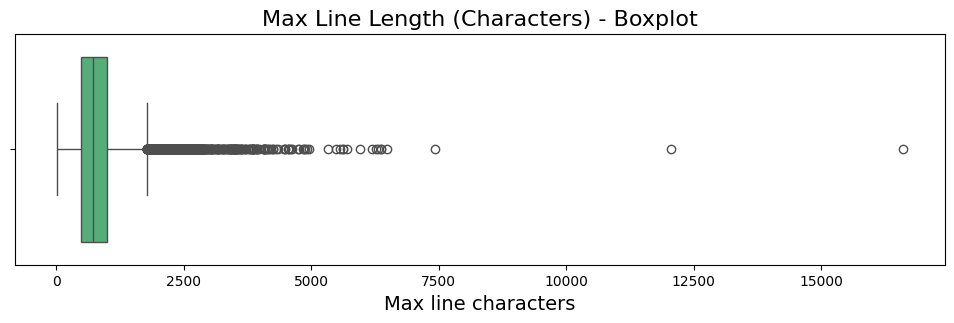

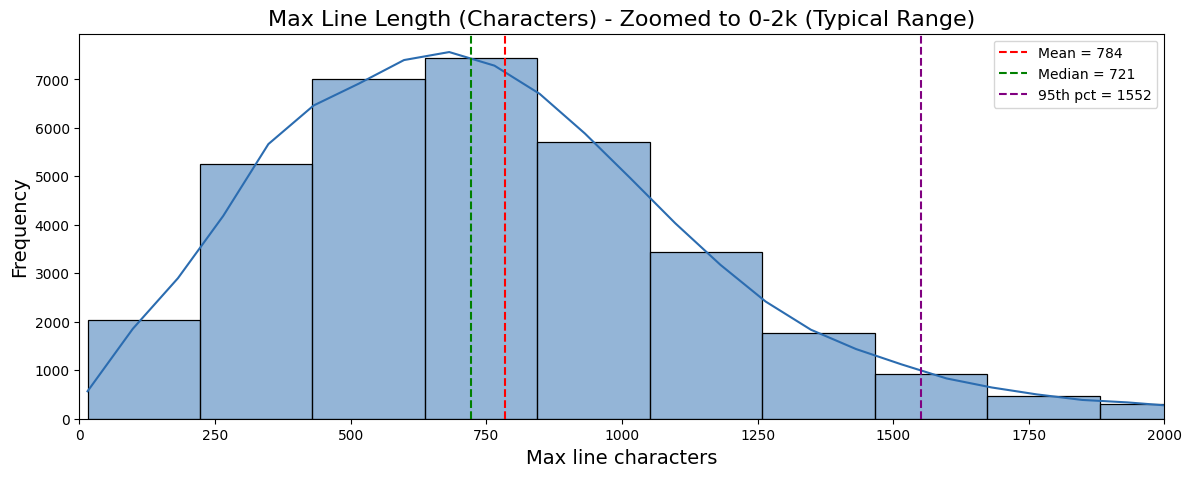

In [11]:
# Maximum line length - full distribution (highlights extreme long lines)
hist(
    df["max_line_chars"],
    "Max Line Length (Characters) - Full Distribution",
    "Max line characters",
    bins=80
)

boxplot(
    df["max_line_chars"],
    "Max Line Length (Characters) - Boxplot",
    "Max line characters"
)

# Maximum line length - zoomed view (typical range is easier to interpret)
hist(
    df["max_line_chars"],
    "Max Line Length (Characters) - Zoomed to 0-2k (Typical Range)",
    "Max line characters",
    bins=80,
    xlim=(0, 2000)
)


To complement the **quantitative analysis**, we inspect a few **representative extreme cases** from the dataset. By displaying plots with the highest values for key structural metrics (number of lines, maximum line length, and number of paragraphs), we can better understand how these characteristics appear in practice and assess whether they require special handling during chunking.

This qualitative step helps validate the metrics and connects distribution-level insights to real text examples.

In [12]:
def show_examples(df: pd.DataFrame, sort_col: str, n: int = 3):
    sample = df.sort_values(sort_col, ascending=False).head(n)
    for idx, row in sample.iterrows():
        print("=" * 80)
        print(f"Title: {row.get('Title')}")
        print(f"{sort_col}: {row[sort_col]}")
        print("-" * 80)
        print(row["plot_norm"][:1200])
        if len(row["plot_norm"]) > 1200:
            print("... [truncated]")
        print()

show_examples(df, "n_lines", n=3)
show_examples(df, "max_line_chars", n=3)
show_examples(df, "n_paragraphs", n=3)


Title: Brigada
n_lines: 53
--------------------------------------------------------------------------------
The film proceeds in chronological order, apart from the scene at the beginning of the first episode before the opening credits, which was taken from Winter 1997.
The film begins in 1989 when Sergeant Alexander (Sasha) Belov, (nicknamed Bely, or white) has finished his national service in the Soviet Border Troops, and returns to his home in Moscow. He is greeted there by his three childhood friends, Kosmos Kholmogorov (or Kosmos (Kos)/Space), Viktor Pchyolkin (Pchyola/Bee), and Valery Filatov (Fil/Phil). His return, however, shows that perestroika has deeply transformed the Soviet Union life and both Kosmos and Pchyola have turned to criminal racket on Moscow's markets. They try to lure Sasha to join them, but Belov abruptly refuses and instead has ambitions to attain higher education in vulcanology.
Belov also learns that his former girlfriend, Yelena Yeliseyeva (Lena, Lenka) ha

## **Interpreting Structural Distributions**

The structural analyses above provide a clear picture of how plot texts are organized in this dataset. Rather than assuming that all chunking strategies are equally suitable, we can now **prioritize or discard approaches based on empirical structural evidence**.

This section synthesizes the observed distributions and explains how they constrain viable chunking strategies.


### **Paragraph structure**

The number of paragraphs per plot is almost always equal to **1**, with only a handful of extreme outliers.

This indicates that paragraph boundaries (`\n\n`) do not encode meaningful structure for the vast majority of plots. In practice, most entries are written as a single uninterrupted block of text, offering little paragraph-level segmentation to exploit.

**Implication**
- Paragraph-aware chunking provides little to no structural benefit for this corpus to justify a paragraph-centric chunking strategy.

### **Line structure**

Most plots contain a small number of lines, but line breaks are used inconsistently across the dataset.

Some plots use line breaks to separate narrative units or scenes, while others are fully linear or contain very long lines without any semantic segmentation. As a result, newline boundaries do not form a stable or universal structural signal.

**Implication**
- Line breaks (`\n`) cannot be assumed to represent reliable semantic boundaries. Line-aware splitting may work for a subset of documents but would fail silently for many others, leading to unpredictable chunking behavior.

### **Maximum line length and overlap constraints**

A critical limitation becomes evident when examining the distribution of maximum line length per plot.

Many plots contain lines spanning **several hundred characters**, with a non-negligible tail of extreme cases extending well beyond typical overlap sizes. This has a direct impact on how overlap behaves in different splitting strategies.

In the standard `CharacterTextSplitter` configured with `separator="\n"`, overlap reuse is only possible if an **entire newline-delimited unit (a full line)** fits within the overlap window. Given realistic overlap values (e.g., `100–300 characters`) and the observed line-length statistics, this condition is rarely satisfied. As a result, overlap reuse frequently collapses to zero, even when an overlap parameter is specified.

**Implication**
- Using newline-based splitting in combination with overlap can give a false sense of continuity: overlap may appear configured, but in practice it often fails to reuse any content due to long lines. Line-based overlap is therefore ineffective and potentially misleading in this dataset.

### **Character length distribution**

In contrast, overall character counts exhibit a **smooth, continuous distribution** with a clear central mass and a manageable long tail.

Unlike paragraphs or lines, character length is:
- Consistently defined across all plots
- Independent of formatting artifacts
- And directly responsible for `chunk size` variability

**Implication**
- Character length provides the most reliable and stable structural signal for defining an initial chunking strategy.

## **From structural evidence to a baseline splitter**

Taken together, these observations suggest that chunking should be **driven primarily by size constraints**, while structural markers (paragraphs, lines, punctuation) should be treated as soft signals: they are leveraged when present, but never enforced as hard constraints during chunk formation.

This distinction clarifies the difference between two commonly used approaches:
- `CharacterTextSplitter` (**with a fixed separator**): 
    - Relies on predefined structural units (e.g., lines) and requires those units to be short enough for overlap reuse. In this dataset, long lines frequently violate that assumption, causing overlap to silently fail.
- `RecursiveCharacterTextSplitter`:
    - Enforces chunk size and overlap at the **character level**, independent of structural unit length. Structural markers are used opportunistically—preferred when available, ignored when unreliable—ensuring predictable chunk sizes and effective overlap even in poorly segmented text.

Crucially, in a recursive strategy, overlap does **not** depend on reusing entire newline-delimited units. Instead, it guarantees a fixed amount of shared context in characters, which is robust to the long-line behavior observed in this corpus.

At the same time, while line breaks (`\n`) cannot be trusted as primary semantic boundaries, they occasionally coincide with natural narrative breaks. Including them as low-priority separators allows the splitter to take advantage of such cases **without depending on them**.

### **Recommended baseline splitter (from structural evidence)**

Based on the empirical findings above, we adopt a **size-first, structure-aware** chunking strategy as an initial, defensible baseline for downstream RAG experiments:

```python
RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ". ", "? ", "! ", "; ", ": ", ", ", " ", ""]
)
```

**Rationale**
- **Why `chunk_size=1200`?**
    - The median plot length lies around ~1.6k characters, with the mean slightly above 2k. A 1200-character chunk keeps most plots within one to two chunks, avoiding excessive fragmentation while preventing very long plots from becoming oversized documents.
- **Why `chunk_overlap=200`?**
    - An overlap of ~200 characters is sufficient to preserve local continuity (entities, references, transitions) across adjacent chunks, while remaining small enough to limit redundancy. Importantly, this overlap is guaranteed regardless of line length.
- **Why include punctuation in `separators`?**
    - Since reliable paragraph and line boundaries are often absent, sentence- and clause-level punctuation (`., ?, !, ;, :`) increases the likelihood that chunk boundaries align with natural stopping points. This reduces mid-sentence splits and improves semantic coherence without imposing rigid structural assumptions.

This baseline reflects a robust compromise between:
- Minimizing unnecessary fragmentation
- Preserving local context across chunks
- And remaining resilient to inconsistent formatting and long-line artifacts